<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#1777C4; border:0' role="tab" aria-controls="home"><center> Modern Parallel and Distributed Python</center></h3>

* [Process-Based Parallelism :multiprocessing ](#1)
* [Joblib](#2)
* [Ray](#3)

Python is long on convenience and programmer-friendliness, but it isn’t the fastest programming language around. Some of its speed limitations are due to its default implementation, cPython, being single-threaded. That is, cPython doesn’t use more than one hardware thread at a time.

And while you can use the threading module built into Python to speed things up, threading only gives you concurrency, not parallelism. It’s good for running multiple tasks that aren’t CPU-dependent, but does nothing to speed up multiple tasks that each require a full CPU. 


Parallel and distributed computing are a staple of modern applications. We need to leverage multiple cores or multiple machines to speed up applications or to run them at a large scale. The infrastructure for crawling the web and responding to search queries are not single-threaded programs running on someone’s laptop but rather collections of services that communicate and interact with one another.

This Notebook  reviews some common options for parallelizing Python code, including process-based parallelism, specialized libraries, ipython parallel,.... and Ray in order  to speed our code for :
    
 **Cross_Validtion/Select Best models**


**Ray**
Developed by a team of researchers at the University of California, Berkeley, Ray underpins a number of distributed machine learning libraries. But Ray isn’t limited to machine learning tasks alone, even if that was its original use case. Any Python tasks can be broken up and distributed across systems with Ray.

Ray’s syntax is minimal, so you don’t need to rework existing apps extensively to parallelize them. The @ray.remote decorator distributes that function across any available nodes in a Ray cluster, with optionally specified parameters for how many CPUs or GPUs to use. The results of each distributed function are returned as Python objects, so they’re easy to manage and store, and the amount of copying across or within nodes is kept to a minimum. This last feature comes in handy when dealing with NumPy arrays, for instance.

Ray even includes its own built-in cluster manager, which can automatically spin up nodes as needed on local hardware or popular cloud computing platforms.


**Dask**

From the outside, Dask looks a lot like Ray. It, too, is a library for distributed parallel computing in Python, with its own task scheduling system, awareness of Python data frameworks like NumPy, and the ability to scale from one machine to many.

Dask works in two basic ways. The first is by way of parallelized data structures — essentially, Dask’s own versions of NumPy arrays, lists, or Pandas DataFrames. Swap in the Dask versions of those constructions for their defaults, and Dask will automatically spread their execution across your cluster. This typically involves little more than changing the name of an import, but may sometimes require rewriting to work completely.

The second way is through Dask’s low-level parallelization mechanisms, including function decorators, that parcel out jobs across nodes and return results synchronously (“immediate” mode) or asynchronously (“lazy”). Both modes can be mixed as needed, too.

One key difference between Dask and Ray is the scheduling mechanism. Dask uses a centralized scheduler that handles all tasks for a cluster. Ray is decentralized, meaning each machine runs its own scheduler, so any issues with a scheduled task are handled at the level of the individual machine, not the whole cluster.

Dask also offers an advanced and still experimental feature called “actors.” An actor is an object that points to a job on another Dask node. This way, a job that requires a lot of local state can run in-place and be called remotely by other nodes, so the state for the job doesn’t have to be replicated. Ray lacks anything like Dask’s actor model to support more sophisticated job distribution.

**Joblib**

Joblib has two major goals: run jobs in parallel and don’t recompute results if nothing has changed. These efficiencies make Joblib well-suited for scientific computing, where reproducible results are sacrosanct. Joblib’s documentation provides plenty of examples for how to use all its features.

Joblib syntax for parallelizing work is simple enough—it amounts to a decorator that can be used to split jobs across processors, or to cache results. Parallel jobs can use threads or processes.
Joblib includes a transparent disk cache for Python objects created by compute jobs. This cache not only helps Joblib avoid repeating work, as noted above, but can also be used to suspend and resume long-running jobs, or pick up where a job left off after a crash. The cache is also intelligently optimized for large objects like NumPy arrays. Regions of data can be shared in-memory between processes on the same system by using numpy.memmap.

One thing Joblib does not offer is a way to distribute jobs across multiple separate computers. In theory it’s possible to use Joblib’s pipeline to do this, but it’s probably easier to use another framework that supports it natively.

**The problem**

Some common data science tasks take a long time to run, but are embarrassingly parallel. Embarrassingly parallel means that they do not depend on each other and could therefore easily be done at the same time. The best examples are training different models and cross validation. In cross validation, training the model on k-1 folds before testing it on the remaining fold and training the model on k-1 different folds before testing it on a different remaining fold are two tasks that are not connected. Because they are not connected, we can handle them to different workers and process them in parallel.

**Process-Based Parallelism :multiprocessing**

The first approach is to use process-based parallelism. With this approach, it is possible to start several processes at the same time (concurrently). This way, they can concurrently perform calculations.

 
Scikit-learn has parallization implemented using its n_jobs option, but we don’t need to rely on its ecosystem to parallelize model selection. Instead, we will use the multiprocessing library directly.
Starting from Python 3, the multiprocessing package is preinstalled and gives us a convenient syntax for launching concurrent processes. It provides the Pool object, which automatically divides input into subsets and distributes them among many processes.

Here is an example of how to use a Pool object to launch ten processes:
    
            import multiprocessing as mp

            num_workers = mp.cpu_count()  

            pool = mp.Pool(num_workers)
            for task in tasks:
                pool.apply_async(func, args = (task,))

            pool.close()
            pool.join()
        
**Select Best Model / Cross Validation Example  :**
    
We can use scikit-learn to conveniently generate the indices for the training and test data for a number of cross-validation folds

In [ ]:
import os
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np 
print('Number of CPUs in the system: {}'.format(os.cpu_count()))

In [ ]:
X1, y1 = make_classification(n_samples=1000, n_features=10, n_informative=5, random_state=123)
X, X_test,y,y_test=train_test_split(X1,y1,test_size=0.2)
splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
folds = list(splitter.split(X, y))
print(len(folds))
print(len(folds[0]),len(folds[1]))

**A cross validation helper Class /Benchmark Models function**

In [ ]:
class CrossValidationParallelism(BaseEstimator, RegressorMixin, TransformerMixin):
    """
    model : model to train in our folds 
    Author : Chaka Abderrazak 
    X : array
    y : array
        """
    def __init__(self, model,X ,y,test):
        self.model = model
        #self.split = split
        self.X = X
        self.y = y
        self.test =test
    def cross_validation(self, split,num_fold):
            """
            Helper function to crossvalidate 
          
            split : tuple
             Training and test indices (train_idx, test_idx)
            """
            X_train, y_train = X[split[0],:], y[split[0]]
            X_val, y_val   = X[split[1],:], y[split[1]]
            # Clone the model 
            self.meta_model_ = clone(self.model)
            results = {}
            # Train the model
            self.meta_model_.fit(X_train, y_train)
            # Make predictions on the val data
            results['pred_val'] = self.meta_model_.predict_proba(X_val)[:,1]
            # Make predictions on the test data
            results['test_pred']= self.meta_model_.predict_proba(X_test)[:,1]
            # Evaluate the model
            results['auc']= roc_auc_score(y_val, results['pred_val'])
            print(f" num of fold : {num_fold}| AUC: {results['auc']}")
            results['num_fold'] =num_fold
            return results
        
        
def benchmark_models( split):
    """
    Helper function to benchmark models
    X : array
    y : array
    split : tuple
     Training and test indices (train_idx, test_idx)
    """
    X_train, y_train = X[split[0],:], y[split[0]]
    X_test, y_test   = X[split[1],:], y[split[1]]
    
    
    model_library = {}
    # One candidate model
    model_library["logit"] = LogisticRegression(solver='liblinear')
    # Another candidate model
    model_library["rf"] = RandomForestClassifier(n_estimators=100, min_samples_leaf=20)

    results = {}
    for model_name, model in model_library.items():
        # Train the model
        model.fit(X_train, y_train)
        # Make predictions on the test data
        pred_test = model.predict_proba(X_test)[:,1]
        # Evaluate the model
        results[model_name] = roc_auc_score(y_test, pred_test)
    
    return pd.DataFrame(results, index = ["ROC-AUC"])
        
      

**Test the Class /Function  for cross validation only one model :**

In [ ]:
model =RandomForestClassifier(n_estimators=100, min_samples_leaf=20)
crossvald = CrossValidationParallelism(model,X ,y,X_test)
results= crossvald.cross_validation(split=folds[0],num_fold=0)
results['auc']

**Test Heleper Fucntion for benchmarking models**

In [ ]:
r =benchmark_models(split=folds[0])
r.head()

<a id=1></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#1777C4; border:0' role="tab" aria-controls="home"><center>Multiprocessing Lib </center></h3>

The multiprocessing library is not particularly geared towards statistics, like scikit-learn. It was difficult for me to figure out which of its functionality is useful for our problem of parallelizing cross validation. To sum up our requirements, we want to:

    Run multiple tasks in parallel
    Pass several arguments to the function
    
We first specify how many processes we want to run in parallel. This number is restricted by the number of cores available. I like to use all but one core on my machine (to avoid programs freezing).
    
On a shared computation server, make sure you understand the policy and be polite by leaving resources for others.

In [ ]:
import multiprocessing as mp
#pool = mp.Pool(3)
# Python can count the available cores for you in most cases
pool = mp.Pool(mp.cpu_count()-1)


Function apply_async can be used to send function calls including additional arguments to one of the processes in the pool. In contrast to apply (without the _async), the program will not wait for each call to be completed before moving on. We can therefore assign the first cross-validation iteration and immidiately assign the second iteration before the first iteration is completed.
There is a drawback to apply_async in that it does not return the result after the call complete. Instead, it returns another object with a get() method. A more convenient solution is a callback. The callback function will be called on the result once the function call is completed. So we’ll specify a list for the results and a callback to save each result into that list.

An important intuition with apply and apply_async is that we assign a single function call to a worker when we call the function. In contrast, the map functionality would assign a list of tasks to available workers at once. apply_async calls the workers into your office one by one to explain their task to them.
IMPORTANT: The results will not come back in the same order as we assigned the tasks. If we want to match the results to each fold, then we should pass an identifier to the function.

**More Explanation from stackoverflow :**

Notice, unlike **pool.map**, the order of the results may not correspond to the order in which the **pool.apply_async** calls were made.

So, if you need to run a function in a separate process, but want the current process to block until that function returns, use Pool.apply. Like P**ool.apply, Pool.map **blocks until the complete result is returned.

If you want the Pool of worker processes to perform many function calls asynchronously, use Pool.apply_async. The order of the results is not guaranteed to be the same as the order of the calls to **Pool.apply_async**.

Notice also that you could call a number of different functions with **Pool.apply_async** (not all calls need to use the same function).

In contrast, Pool.map applies the same function to many arguments. However, unlike **Pool.apply_async**, the results are returned in an order corresponding to the order of the arguments.

In [ ]:
%%time
results = []
def log_result(x):
    results.append(x)
    
for fold in folds:
    pool.apply_async(benchmark_models, args=(fold,), callback = log_result)
    #results.append(pool.apply_async(benchmark_models, args=(X, y, fold)).get())

After assigning each task the program moves on without waiting for the result from the worker. That was convenient when we assigned the tasks and didn’t want to wait for the first result before assigning the second task. But we ususally want to wait for all results before moving on with script and, for example, average the results.
We tell the program to wait for all workers to complete their tasks using the method join(). Before we do so, we are required to make sure that no new tasks are assigned, which we do by using close() on the pool.



In [ ]:
# Close the pool for new tasks
pool.close()
# Wait for all tasks to complete at this point
pool.join()


In [ ]:
# After collecting the results, we can work with the data as usual.
result = pd.concat(results, axis=0, sort=True)
result.head()

For cross validation, we would usually average the results over all splits and then compare our models.

In [ ]:
result.index.name = "metric"
result.reset_index()
average = result.groupby(['metric']).mean()
average.head()

Python does include a native way to run a Python workload across multiple CPUs. The multiprocessing module spins up multiple copies of the Python interpreter, each on a separate core, and provides primitives for splitting tasks across cores. But sometimes even multiprocessing isn’t enough.




<a id=2></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#1777C4; border:0' role="tab" aria-controls="home"><center>Joblib</center></h3>


Joblib is a set of tools to provide lightweight pipelining in Python. In particular:

    transparent disk-caching of functions and lazy re-evaluation (memoize pattern)
    easy simple parallel computing

Joblib is optimized to be fast and robust on large data in particular and has specific optimizations for numpy arrays. It is BSD-licensed.

Example :

        >>> from math import modf
        >>> from joblib import Parallel, delayed
        >>> r = Parallel(n_jobs=1)(delayed(modf)(i/2.) for i in range(10))
        >>> res, i = zip(*r)
        >>> res

In [ ]:
%%time
from joblib import Parallel, delayed
crossvald = CrossValidationParallelism(model,X ,y,X_test)
results_joblib  = Parallel(n_jobs=3, verbose=100)(
delayed(crossvald.cross_validation)(fold,num ) for num,  fold in enumerate(folds) )
# After collecting the results, we can work with the data as usual.
for i in results_joblib : 
    print(i['auc'] ,i['num_fold'])

**n_jobs=-1: use all available cores**

# Complete result 

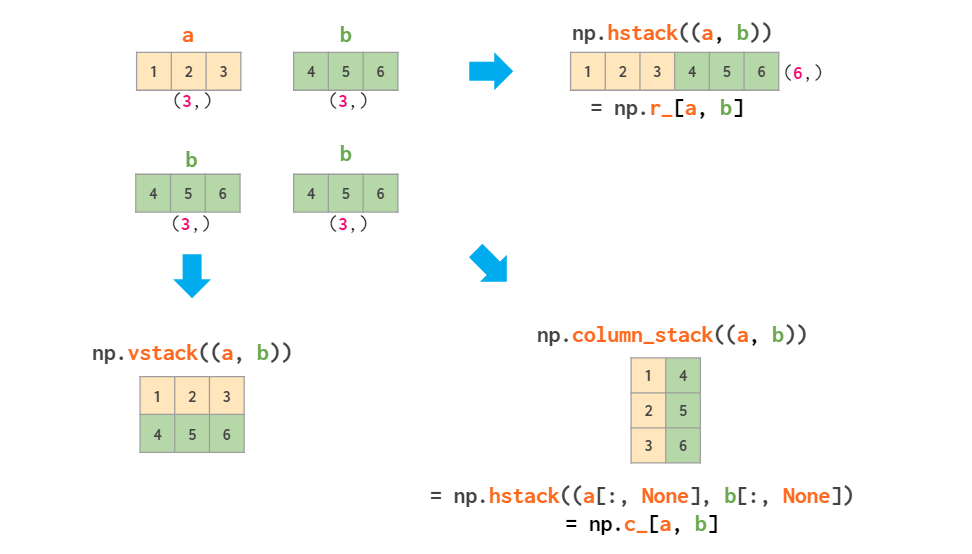

In [ ]:
for i in results_joblib :
    reuslt = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in i.items() ]))
    # final = pd.concat(reuslt)
    print(reuslt.head(2))

**Out_of_fold_predictions**


In [ ]:
np.hstack([ i['pred_val'] for i in results_joblib])[0:3]

**Test prediction**

In [ ]:
import numpy as np  
np.column_stack([ i['test_pred'] for i in results_joblib])[0:10]

 **Test final prediction :**

In [ ]:
np.column_stack([ i['test_pred'] for i in results_joblib]).mean(axis=1)[0:3]

**Overall predictions :**

In [ ]:
np.column_stack([ i['auc'] for i in results_joblib]).mean(axis=1)

In the Parallel constructor you use the delayed argument to designate the function you want to run in parallel. delayed returns a new function that wraps your function. You can then call the newly wrapped function with arguments that'll be passed to your original function.

 
 <a id=3></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#1777C4; border:0' role="tab" aria-controls="home"><center>Ray</center></h3>


Scikit-learn parallelizes training on a single node using the joblib parallel backends. Joblib instantiates jobs that run on multiple CPU cores. The parallelism of these jobs is limited by the number of CPU cores available on that node. The current implementation of joblib is optimized for a single node, but why not go further and distribute it on multiple nodes?

Running distributed applications on multiple nodes introduces a host of new complexities like scheduling tasks across multiple machines, transferring data efficiently, and recovering from machine failures. Ray handles all of these details while keeping things simple.


I'll describe how to use Ray to easily build applications that can scale from your laptop to a large cluster.

**Why Ray?**

Many tutorials explain how to use Python’s multiprocessing module. Unfortunately the multiprocessing module is severely limited in its ability to handle the requirements of modern applications. These requirements include the following:

    Running the same code on more than one machine.
    
    Building microservices and actors that have state and can communicate.
    
    Gracefully handling machine failures.
    
    Efficiently handling large objects and numerical data.

Ray addresses all of these points, makes simple things simple, and makes complex behavior possible.


**Necessary Concepts**


Traditional programming relies on two core concepts: functions and classes. Using these building blocks, programming languages allow us to build countless applications.

However, when we migrate our applications to the distributed setting, the concepts typically change.

On one end of the spectrum, we have tools like OpenMPI, Python multiprocessing, and ZeroMQ, which provide low-level primitives for sending and receiving messages. These tools are very powerful, but they provide a different abstraction and so single-threaded applications must be rewritten from scratch to use them.

On the other end of the spectrum, we have domain-specific tools like TensorFlow for model training, Spark for data processing and SQL, and Flink for stream processing. These tools provide higher-level abstractions like neural networks, datasets, and streams. However, because they differ from the abstractions used for serial programming, applications again must be rewritten from scratch to leverage them.


Ray occupies a unique middle ground. Instead of introducing new concepts. Ray takes the existing concepts of functions and classes and translates them to the distributed setting as tasks and actors. This API choice allows serial applications to be parallelized without major modifications.
    
**Starting Ray**

The ray.init() command starts all of the relevant Ray processes. On a cluster, this is the only line that needs to change (we need to pass in the cluster address). These processes include the following:

    A number of worker processes for executing Python functions in parallel (roughly one worker per CPU core).
    A scheduler process for assigning “tasks” to workers (and to other machines). A task is the unit of work scheduled by Ray and corresponds to one function invocation or method invocation.
    A shared-memory object store for sharing objects efficiently between workers (without creating copies).
    An in-memory database for storing metadata needed to rerun tasks in the event of machine failures.

Ray workers are separate processes as opposed to threads because support for multi-threading in Python is very limited due to the global interpreter lock.

**Parallelism with Tasks**

To turn a Python function f into a “remote function” (a function that can be executed remotely and asynchronously), we declare the function with the @ray.remote decorator. Then function invocations via f.remote() will immediately return futures (a future is a reference to the eventual output), and the actual function execution will take place in the background (we refer to this execution as a task).

 Example : 
    
            import ray
            import time
            ray.shutdown()
            # Start Ray.
            ray.init()

            @ray.remote
            def f(x):
                time.sleep(1)
                return x

            # Start 4 tasks in parallel.
            result_ids = []
            for i in range(4):
                result_ids.append(f.remote(i))

            # Wait for the tasks to complete and retrieve the     results.
            # With at least 4 cores, this will take 1 second.
            results = ray.get(result_ids)  # [0, 1, 2, 3]

Because the call to f.remote(i) returns immediately, four copies of f can be executed in parallel simply by running that line four times.


In [ ]:
%%time
import numpy as np
import ray
import time
ray.shutdown()
# Start Ray.
ray.init()
# Define our Class
class CrossValidationParallelism(BaseEstimator, RegressorMixin, TransformerMixin):
    """
    model : model to train in our folds 

    X : array
    y : array
        """
    def __init__(self, model,X ,y,test):
        self.model = model
        #self.split = split
        self.X = X
        self.y = y
        self.test =test
    def cross_validation(self, split,num_fold):
            """
            Helper function to crossvalidate 
          
            split : tuple
             Training and test indices (train_idx, test_idx)
            """
            X_train, y_train = X[split[0],:], y[split[0]]
            X_val, y_val   = X[split[1],:], y[split[1]]
            # Clone the model 
            self.meta_model_ = clone(self.model)
            results = {}
            # Train the model
            self.meta_model_.fit(X_train, y_train)
            # Make predictions on the val data
            results['pred_val'] = self.meta_model_.predict_proba(X_val)[:,1]
            # Make predictions on the test data
            results['test_pred']= self.meta_model_.predict_proba(X_test)[:,1]
            # Evaluate the model
            results['auc']= roc_auc_score(y_val, results['pred_val'])
            print(f" num of fold : {num_fold}| AUC: {results['auc']}")
            results['num_fold'] =num_fold
            return results

# Start 3 tasks in parallel.
@ray.remote
def cross_validation_helper(fold,num):
    crossvald = CrossValidationParallelism(model,X ,y,X_test)
    results = crossvald.cross_validation(fold,num)
    return results 

result_ids = [cross_validation_helper.remote(fold,num) for  num,  fold in enumerate(folds)]

In [ ]:
values = ray.get(result_ids)

In [ ]:
 np.column_stack([ i['auc'] for i in values]).mean(axis=1)


**Distributed Scikit-Learn with Ray**

Scikit-learn parallelizes training on a single node using the joblib parallel backends. Joblib instantiates jobs that run on multiple CPU cores. The parallelism of these jobs is limited by the number of CPU cores available on that node. The current implementation of joblib is optimized for a single node, but why not go further and distribute it on multiple nodes?

Running distributed applications on multiple nodes introduces a host of new complexities like scheduling tasks across multiple machines, transferring data efficiently, and recovering from machine failures. Ray handles all of these details while keeping things simple.

Ray is a fast and simple framework for building and running distributed applications. Ray also provides many libraries for accelerating machine learning workloads. If your scikit-learn code takes too long to run and has a high degree of parallelism, using the Ray joblib backend could help you to seamlessly speed up your code from your laptop to a remote cluster by adding four lines of code that register and specify the Ray backend.


**A More Complete Example**

Here’s a more complete example that does hyperparameter tuning of an SVM with cross-validation using random search.

In [ ]:
import numpy as np
from joblib import parallel_backend # added line.
from sklearn.datasets import load_digits
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC      

from ray.util.joblib import register_ray # added line.
register_ray() # added line.

param_space = {
    'C': np.logspace(-6, 6, 10),
    'gamma': np.logspace(-8, 8, 10),
    'tol': np.logspace(-4, -1, 10),
    'class_weight': [None, 'balanced'],
}

model = SVC(kernel='rbf')
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=300,verbose=1)
digits = load_digits()
#ray.init(address=”auto”)
with parallel_backend('ray'): # added line.
    search.fit(digits.data, digits.target)

The lines that were added to the original code are #2,#7,#8, and #21. Note that so far, this code will run on multiple cores but only on a single node, because we haven’t specified how to connect to a Ray cluster yet.

To run it on a Ray cluster add ray.init(address=”auto”) or ray.init(address=”<address:port>”) before calling
with parallel_backend(“ray”) as shown in line #20. 


In [ ]:
search.best_params_ 

**Experimental Results**
Those results comes from this  article : 
    
https://medium.com/distributed-computing-with-ray/easy-distributed-scikit-learn-training-with-ray-54ff8b643b33
    
To evaluate the benefits of distributing scikit-learn with Ray, we run hyperparameter tuning with random and grid search on SVM classifiers and random forests using the scikit-learn digits dataset. The code to reproduce the results is available here. We start with a single m5.8xlarge node with 32 cores on AWS. Then we increase the number of nodes to five and then to ten. We compare the Ray backend to the Loky, Multiprocessing, and Dask backends.

The following figure shows the performance comparison on a random forest benchmark as well as two SVM hyperparameter tuning benchmarks. For random forests, we use 45,000 trees. For hyperparameter tuning, we use 1,500 configurations for random search and 20,000 for grid search. The performance in terms of execution time is normalized to the performance of the scikit-learn default Loky backend (in the plots, higher is better).

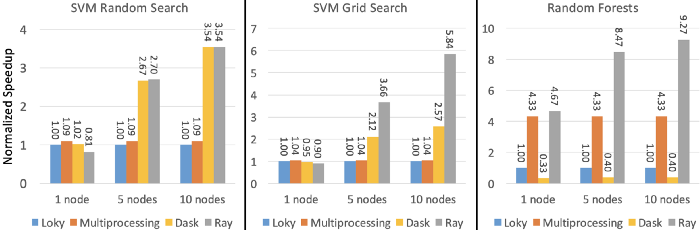

On multiple nodes, Ray outperforms the other backends. Ray performs significantly better in the random forest benchmark. Ray shines in this workload due to the large number of tree estimators used, which results in 45,000 tasks being submitted (compared to 1,500 tasks in hyperparameter tuning with random search and 20,000 in grid search). Ray’s high-throughput decentralized scheduler along with its use of shared memory allow Ray to scale this workload efficiently to multiple nodes. The performance improvement as we add more nodes increases but is bottlenecked mainly by the serial part of the program (Amdahl’s law). Adding more hyperparameters to tune can further improve the parallelism and result in improved scalability.


**Conclusion**

In this Notebook , we showed how you can scale your scikit-learn applications to a cluster with Ray’s implementation of joblib’s backend, by adding four lines of code.

This is only one of many powerful libraries built to scale using Ray, including Tune, a scalable hyperparameter tuning library and RLlib, a scalable reinforcement learning library.


 **Upvote if  you  find it Useful**

# Reference : 

https://docs.ray.io/en/latest/joblib.html

https://cosmiccoding.com.au/tutorials/multiprocessing

https://joblib.readthedocs.io/en/latest/parallel.html

difference between ray and spark : 
https://www.youtube.com/watch?v=yLKHHiT2nWw&list=PLmetp36hFxeyc9qO_5tPNMW-YD3tZfCFN&index=6

https://towardsdatascience.com/parallelizing-python-code-3eb3c8e5f9cd?fbclid=IwAR2iuV1PBMa6Zp46hFG4R-b_Vr0AYOXefpvEbRRnqRn8xdA_HSOorj0zZ98

https://johaupt.github.io/python/parallel%20processing/cross-validation/multiprocessing_cross_validation.html